Reference: https://qiita.com/sasayabaku/items/b7872a3b8acc7d6261bf

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

In [3]:
# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

In [4]:
f = toy_problem()

In [5]:
f

array([-0.01193682,  0.11267561,  0.14199647,  0.16555451,  0.19886137,
        0.31630199,  0.35251922,  0.40271302,  0.48671221,  0.56576344,
        0.62410516,  0.63947192,  0.68877586,  0.74403342,  0.79650712,
        0.77839007,  0.88825983,  0.85449988,  0.88583114,  0.92505868,
        0.95187381,  0.95301373,  0.94525834,  1.01465892,  0.9914845 ,
        1.04695749,  0.96063397,  0.99140423,  0.95274369,  1.00643078,
        0.95760153,  0.91212627,  0.93495445,  0.91320943,  0.810966  ,
        0.83381369,  0.72309191,  0.75688181,  0.68566248,  0.6611494 ,
        0.61712537,  0.4992037 ,  0.47601527,  0.40427508,  0.37098485,
        0.33093935,  0.2572944 ,  0.21371934,  0.16438919,  0.06939626,
       -0.01224426, -0.08903773, -0.14330899, -0.13933668, -0.27513388,
       -0.29284816, -0.39648634, -0.44318794, -0.51893781, -0.54322375,
       -0.62828833, -0.65922667, -0.68004001, -0.76395488, -0.75919752,
       -0.84235994, -0.88947456, -0.86876275, -0.93142037, -0.94

In [38]:
def make_dataset(low_data, n_prev=100, maxlen=25):
    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target

In [7]:
#g -> 学習データ， h -> 学習ラベル
g, h = make_dataset(f)

In [10]:
print(g.shape)
g

(176, 25, 1)


array([[[-0.01193682],
        [ 0.11267561],
        [ 0.14199647],
        ...,
        [ 0.94525834],
        [ 1.01465892],
        [ 0.9914845 ]],

       [[ 0.11267561],
        [ 0.14199647],
        [ 0.16555451],
        ...,
        [ 1.01465892],
        [ 0.9914845 ],
        [ 1.04695749]],

       [[ 0.14199647],
        [ 0.16555451],
        [ 0.19886137],
        ...,
        [ 0.9914845 ],
        [ 1.04695749],
        [ 0.96063397]],

       ...,

       [[-1.00888853],
        [-1.02185926],
        [-0.99950483],
        ...,
        [-0.33267815],
        [-0.23083245],
        [-0.18753457]],

       [[-1.02185926],
        [-0.99950483],
        [-1.03071334],
        ...,
        [-0.23083245],
        [-0.18753457],
        [-0.14597901]],

       [[-0.99950483],
        [-1.03071334],
        [-0.9433921 ],
        ...,
        [-0.18753457],
        [-0.14597901],
        [-0.01783332]]])

In [11]:
print(h.shape)
h

(176, 1)


array([[ 1.04695749],
       [ 0.96063397],
       [ 0.99140423],
       [ 0.95274369],
       [ 1.00643078],
       [ 0.95760153],
       [ 0.91212627],
       [ 0.93495445],
       [ 0.91320943],
       [ 0.810966  ],
       [ 0.83381369],
       [ 0.72309191],
       [ 0.75688181],
       [ 0.68566248],
       [ 0.6611494 ],
       [ 0.61712537],
       [ 0.4992037 ],
       [ 0.47601527],
       [ 0.40427508],
       [ 0.37098485],
       [ 0.33093935],
       [ 0.2572944 ],
       [ 0.21371934],
       [ 0.16438919],
       [ 0.06939626],
       [-0.01224426],
       [-0.08903773],
       [-0.14330899],
       [-0.13933668],
       [-0.27513388],
       [-0.29284816],
       [-0.39648634],
       [-0.44318794],
       [-0.51893781],
       [-0.54322375],
       [-0.62828833],
       [-0.65922667],
       [-0.68004001],
       [-0.76395488],
       [-0.75919752],
       [-0.84235994],
       [-0.88947456],
       [-0.86876275],
       [-0.93142037],
       [-0.94479728],
       [-0

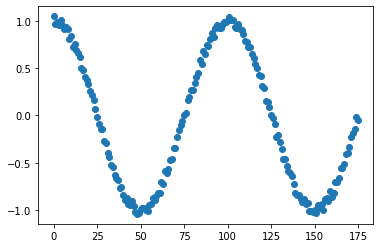

In [18]:
#h.reshape(h.shape[0])
#[i for i in range(h.shape[0])]

plt.scatter([i for i in range(h.shape[0])], h.reshape(h.shape[0]))

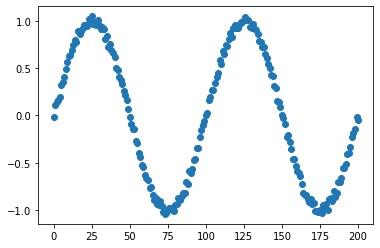

In [19]:
plt.scatter([i for i in range(len(f))], f)

### モデル構築

In [20]:
# 1つの学習データのStep数(今回は25)
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 300

In [21]:
model = Sequential()

model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))

optimizer = Adam(lr=0.001)

model.compile(loss="mean_squared_error", optimizer=optimizer)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

hist = model.fit(g, h,
                 batch_size=300,
                 epochs=100,
                 validation_split=0.1,
                 callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 8/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/100
1/1 [=

<AxesSubplot:>

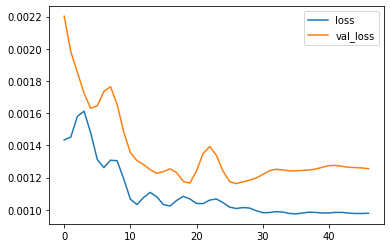

In [24]:
import pandas as pd

results = pd.DataFrame(hist.history)
results[['loss', 'val_loss']].plot()

### 予測

In [25]:
predicted = model.predict(g)

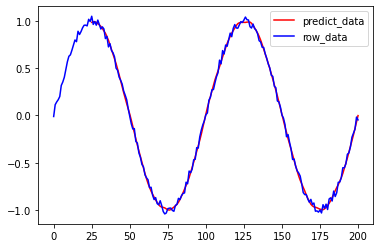

In [26]:
plt.figure()
plt.plot(range(25,len(predicted)+25), predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.legend()
plt.show()

### 未来の予測

In [29]:
future_test = g[-1].T

In [31]:
print(future_test.shape)
future_test

(1, 25)


array([[-0.99950483, -1.03071334, -0.9433921 , -0.98206787, -0.93776876,
        -0.99437495, -0.88329908, -0.87072419, -0.90459044, -0.79963241,
        -0.85706216, -0.81678317, -0.70691307, -0.70435629, -0.65851773,
        -0.55305635, -0.55362997, -0.51231453, -0.41102409, -0.39599511,
        -0.33267815, -0.23083245, -0.18753457, -0.14597901, -0.01783332]])

In [32]:
# 1つの学習データの時間の長さ -> 25
time_length = future_test.shape[1]

# 未来の予測データを保存していく変数
future_result = np.empty((1))

# 未来予想
for step2 in range(400):
    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)

In [33]:
future_result

array([-0.01783332, -0.00240422,  0.06752776,  0.13560309,  0.20123096,
        0.26587611,  0.32876724,  0.39078879,  0.4502005 ,  0.50794935,
        0.56419659,  0.61736506,  0.66896546,  0.71768826,  0.76280129,
        0.80537033,  0.84471506,  0.88016516,  0.91279942,  0.94195694,
        0.96698517,  0.98883432,  1.006863  ,  1.02071047,  1.03107405,
        1.03789592,  1.04026747,  1.03952897,  1.03498721,  1.02673006,
        1.01483965,  0.99937695,  0.98041105,  0.95800364,  0.93223768,
        0.90318757,  0.87093014,  0.83556414,  0.79717517,  0.75586915,
        0.71176416,  0.66497248,  0.61562186,  0.56385487,  0.50981128,
        0.45364931,  0.39554465,  0.33567461,  0.27423668,  0.21144478,
        0.14751913,  0.08269527,  0.01723166, -0.04861421, -0.11456393,
       -0.18032911, -0.24561265, -0.31011048, -0.37351382, -0.43551245,
       -0.4957976 , -0.55406517, -0.61001968, -0.66337729, -0.71386987,
       -0.76124781, -0.80528271, -0.84577024, -0.882532  , -0.91

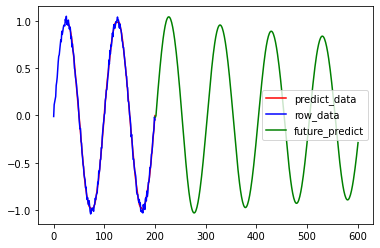

In [34]:
# sin波をプロット
plt.figure()
plt.plot(range(25,len(predicted)+25), predicted, color="r", label="predict_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()